# Fine-tuning Mistral on JSON data

#### OOM errors

If you get an error: `OutOfMemoryError: CUDA out of memory`, tweak your parameters to make the model less computationally expensive.

### 1. Load Packages/Dataset

In [1]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib
#!pip uninstall -y transformers
#!pip install transformers
!pip install jsonl2json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

#### Print Versions (for requirements.txt)

In [3]:
import pkg_resources

packages = [
    "bitsandbytes",
    "transformers",
    "peft",
    "accelerate",
    "datasets",
    "scipy",
    "ipywidgets",
    "matplotlib",
    "jsonl2json"
]
from importlib.metadata import version
for pkg in packages:
    print(pkg, version(pkg))

bitsandbytes 0.43.0
transformers 4.40.0.dev0
peft 0.10.1.dev0
accelerate 0.29.0.dev0
datasets 2.18.0
scipy 1.12.0
ipywidgets 8.1.2
matplotlib 3.8.3
jsonl2json 1.0.0


#### This mounting step is for if you are using Colab

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Convert JSONL to JSON (not necessary if data is already JSON)

In [12]:
from jsonl2json import JsonlToJsonFormatter
import json
import os

file_path = '/content/drive/MyDrive/CMSE495_FineTune/OSW_labeled_data.json'  # UPDATE THIS WITH THE PATH TO YOUR DATA IF YOU USE YOUR OWN
#file_path = '/content/drive/MyDrive/CMSE495_FineTune/SIFT_data_2024_03.jsonl'  # UPDATE THIS WITH THE PATH TO YOUR DATA IF YOU USE YOUR OWN

# Extract the file extension to determine the file type
file_ext = os.path.splitext(file_path)[1]

# Check if the file is a JSON Lines file
if file_ext == '.jsonl':
    # if the file is a JSONL file, proceed with conversion
    output_file_path = file_path.rsplit('.', 1)[0] + '.json'  # replace .jsonl with .json
    jsonl = JsonlToJsonFormatter(file_path, output_file_path)
    jsonl.to_json()
    file_path = output_file_path  # set file path to the new .json path

In [13]:
# Correct your path to match the mounted Google Drive structure
# Load the JSON data
with open(file_path, 'r') as f:
    osw_data = json.load(f)

osw_data[0]

{'text': 'most fishermen observed an increase in recreational fishing in the BIWF area',
 'causal relations': [{'src': 'BIWF',
   'tgt': 'recreational fishing',
   'direction': 'increase'}],
 'meta_data': {'title': 'Integrating social and ecological research on the impacts of offshore wind farms in North America',
  'authors': 'ten Brink, Talya; Dalton, Tracey; Livermore, Julia',
  'year': 2020}}

#### Split into train/test if there aren't separate train/val datasets

In [14]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(osw_data, test_size=0.2, random_state=42)

### Accelerator

Set up the Accelerator.

In [15]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [16]:
def format_for_training(entry):
    text = entry["text"]
    relations_str = "; ".join([f"source: {rel['src']}, target: {rel['tgt']}, direction: {rel['direction']}" for rel in entry["causal relations"]])
    formatted_entry = f"text: {text} \nrelations: {relations_str}"
    return formatted_entry

# THIS IS THE FORMATTING FUNCTION THAT WE USE FOR OSW_DATA

In [ ]:
# EXAMPLE FORMATTING FUNCTION IF YOU HAVE INPUT/OUTPUT DATA

# def formatting_func(example):
#     text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
#     return text

### 2. Load Base Model

Load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization

In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


Graph length distribution to pick best `model_max_length`

In [18]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(entry):
    formatted_prompt = format_for_training(entry)
    return tokenizer(formatted_prompt)

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Reformat the prompt and tokenize each sample:

In [19]:
tokenized_train_dataset = [generate_and_tokenize_prompt(entry) for entry in train_data]  # WE TOKENIZE IN THIS FORMAT BECAUSE WE READ IN OUR DATA AS LISTS
tokenized_val_dataset = [generate_and_tokenize_prompt(entry) for entry in val_data]

In [ ]:
# IF DATA IS IN AN ARRAY, YOU CAN USE .map()

# tokenized_train_dataset = train_data_formatted.map(generate_and_tokenize_prompt)
# tokenized_val_dataset = val_data_formatted.map(generate_and_tokenize_prompt)

Visualize distribution of our dataset lengths to determine the appropriate `max_length` for input tensors.

20


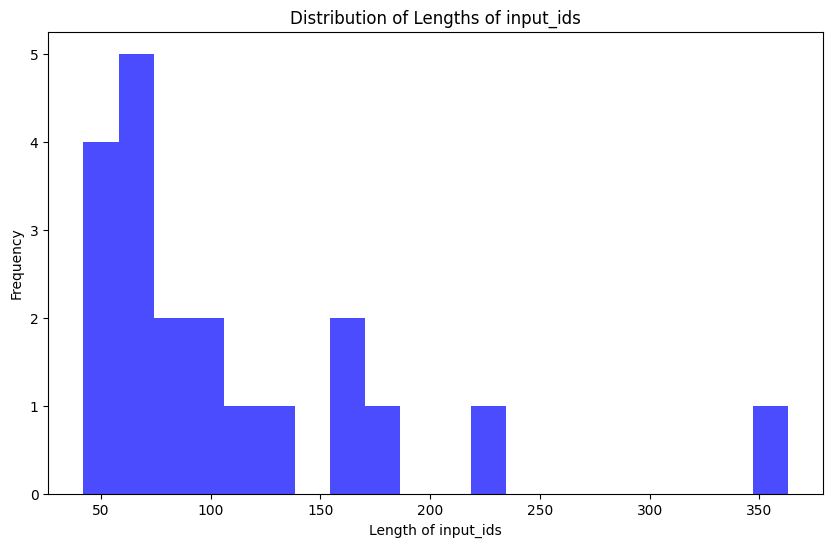

In [20]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

Tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [21]:
max_length = 400 # This was an appropriate max length for my dataset (see graph above)

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        format_for_training(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [22]:
# FOR LISTS
tokenized_train_dataset = [generate_and_tokenize_prompt2(entry) for entry in train_data]
tokenized_val_dataset = [generate_and_tokenize_prompt2(entry) for entry in val_data]

# FOR ARRAYS
# tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
# tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [23]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2245, 28747, 5299, 26336, 4658, 3654, 15189, 3414, 304, 13133, 28725, 7949, 302, 459, 1413, 5148, 301, 1350, 31

Now all the samples should be the same length, `max_length`.

20


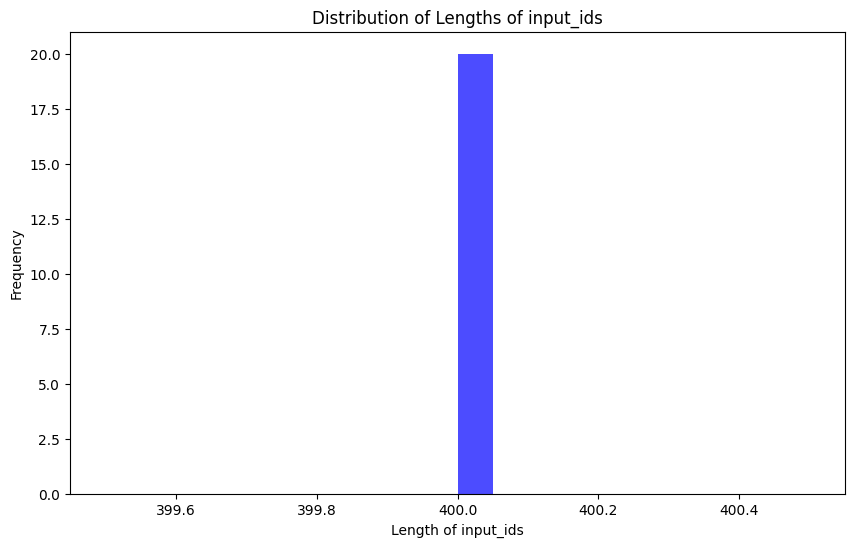

In [24]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### 4. Set Up LoRA

Preprocess the model to prepare it for training. Use the `prepare_model_for_kbit_training` method from PEFT

In [25]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [26]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Print the model to examine its layers.
We will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head` (FOR MISTRAL)

In [27]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Define the LoRA config.

`r` = rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` = scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well.
We use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [28]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [29]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

### 5. Run Training!

Note on training: you can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 100 steps, and find that at around 50 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`mistral-OSW-finetune`) as your final model in step 6 below.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you don't need to train anymore (when loss begins increasing).

In [30]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [31]:
model = accelerator.prepare_model(model)

In [32]:
import transformers
from datetime import datetime

project = "OSW-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=15,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        #bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=1,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=1,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=1,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        #report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1,3.117000,1.920711
2,3.533800,1.776552
3,2.301700,1.687635
4,2.128800,1.610395
5,1.896400,1.548159
6,2.426200,1.489272
7,1.713100,1.454935
8,1.501200,1.411813
9,1.785200,1.387262
10,2.054600,1.370864


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=15, training_loss=2.0007617235183717, metrics={'train_runtime': 402.9696, 'train_samples_per_second': 0.074, 'train_steps_per_second': 0.037, 'total_flos': 518090489856000.0, 'train_loss': 2.0007617235183717, 'epoch': 1.88})

### 6. Try the Trained Model!

On Colab: kill the current process to not run out of memory loading the base model again on top of the model we just trained.
Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so first load the base model from the Huggingface Hub:

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-OSW-finetune/checkpoint-15")

and run your inference

Create an `eval_prompt` and `model_input` and see if the new finetuned model performs better.

In [7]:
eval_prompt1 = """
### Text:
In addition, for navigation safety, fisheries are in some cases excluded or restricted within the wind farm area.

### Task:
Identify the causal relations in the text above. For each relation, provide the source (src), target (tgt), and direction of the relation. Format your response as follows:

- Source (src): [source entity]
- Target (tgt): [target entity]
- Direction: [increase or decrease]

### Causal Relations:
"""
eval_prompt2 = """
### Text:
most fishermen observed an increase in recreational fishing in the BIWF area

### Task:
Identify the causal relations in the text above. For each relation, provide the source (src), target (tgt), and direction of the relation. Format your response as follows:

- Source (src): [source entity]
- Target (tgt): [target entity]
- Direction: [increase or decrease]

### Causal Relations:
"""

model_input = eval_tokenizer(eval_prompt2, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



### Text:
most fishermen observed an increase in recreational fishing in the BIWF area

### Task:
Identify the causal relations in the text above. For each relation, provide the source (src), target (tgt), and direction of the relation. Format your response as follows:

- Source (src): [source entity]
- Target (tgt): [target entity]
- Direction: [increase or decrease]

### Causal Relations:
- src: most fishermen; tgt: recreational fishing; dir: increase
- src: BIWF area; tgt: recreational fishing; dir: increase

### Explanation:
The text states that "most fishermen observed an increase in recreational fishing in the BIWF area." This indicates a causal relationship between two entities: "most fishermen" and "recrational fishing". The direction of this relationship is an increase,
